# 🗺️ Network Analysis with Python

#### **Universidad Nacional de Colombia**  
*Facultad de Ciencias Agrarias*  

**Student:** Paula Andrea Cardona Velásquez

**Lecturer:** Liliana Castillo Villamor

## 🔧 Environment Setup Summary

The following Docker image was created, configured, and published to ensure a stable and reproducible environment for this workshop:

- 🐳 **Custom Docker Image** based on `python:3.10-slim`
- 📦 Installed packages for network analysis: `osmnx`, `networkx`, `pandas`, `matplotlib`, `seaborn`, `scipy`, and `python-louvain`
- 💻 Included JupyterLab 4.4.3
- 📁 Mounted local folder
- 🔐 Version-controlled using Git and GitHub

The notebook you're viewing was developed and committed directly from a JupyterLab session running in Docker. Everything was pushed to the public GitHub repository https://github.com/pcardonav/workshop4-network-analysis.git

➡️ Docker image in docker hub:  
https://hub.docker.com/r/pcardonav/paula_image

**Pull the Docker image** from Docker Hub:
```bash
docker pull pcardonav/paula_image:latest
```

**Run de image**
```bash
docker run -it -p 8888:8888 -v "YOR_PATH":/notebooks pcardonav/paula_image:latest

## Environment Check & Imports
Before diving into data acquisition, we ensure that all required libraries are available in the running Docker container and record their versions for reproducibility.

In [1]:
# ⚙️ Environment Check & Imports
import sys, platform, os
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

print("Python :", sys.version.split()[0])
print("Platform:", platform.platform())
print("osmnx  :", ox.__version__)
print("networkx:", nx.__version__)
print("geopandas:", gpd.__version__)
print("pandas :", pd.__version__)
print("matplotlib:", matplotlib.__version__)

Python : 3.10.18
Platform: Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.36
osmnx  : 2.0.4
networkx: 3.4.2
geopandas: 1.1.0
pandas : 2.3.0
matplotlib: 3.10.3


## NetworkX "Warm-Up"
To refresh core graph concepts, we create a tiny undirected graph with three nodes and one edge.  
This example demonstrates how to add nodes/edges, inspect their attributes, and produce a quick visualisation.

Nodes : [1, 2, 3, 4]
Edges : [(1, 3)]


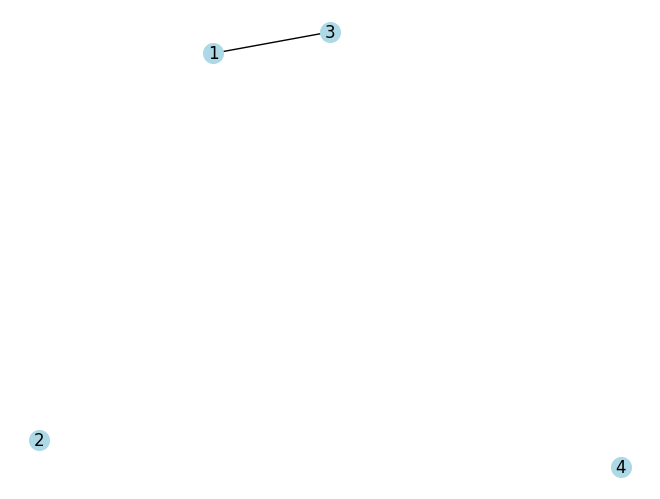

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty, undirected graph
G = nx.Graph()

# Add nodes and one edge
G.add_nodes_from([1, 2, 3, 4])
G.add_edge(1, 3)

# Inspect nodes and edges
print("Nodes :", list(G.nodes()))
print("Edges :", list(G.edges()))

# Attach metadata
G.nodes[1]["label"] = "blue"

# Basic visualisation
nx.draw(G, with_labels=True, node_color="lightblue", node_size=200)
plt.show()

The **NetworkX** package offers low-level tools to analyse graphs, while **OSMnx** provides high-level helpers to download routable street networks from OpenStreetMap for different travel modes (walking, cycling, driving).  

In the next cell we use `osmnx.graph_from_place()` to grab the **walkable road network** of *Comuna 5, Ibagué (Tolima, Colombia)*.

## 1. Obtain a routable network

To download OpenStreetMap data that represents the street network, we can use
it’s
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
function. As parameters, it expects a place name and, optionally, a network
type.

Downloaded walk network for 3 communes in Ibagué
Nodes : 1,880
Edges : 5,644


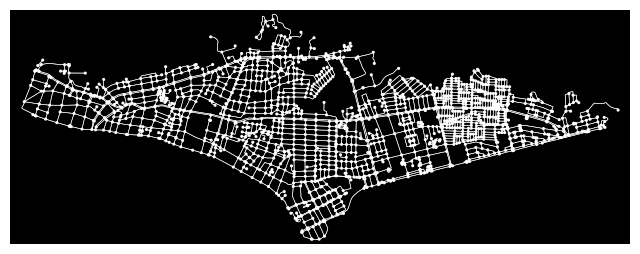

Graph saved to: data/raw/Ibague_comuna4_5_walk.graphml


In [2]:
import osmnx as ox

PLACE_NAMES = [
    "Comuna 3, Ibagué, Tolima, Colombia",
    "Comuna 4, Ibagué, Tolima, Colombia",
    "Comuna 5, Ibagué, Tolima, Colombia"
]
NETWORK_TYPE = "walk"


graph = ox.graph_from_place(
    PLACE_NAMES,
    network_type=NETWORK_TYPE,
    simplify=True
)

# Quick diagnosis
stats = ox.basic_stats(graph)
print(f"Downloaded {NETWORK_TYPE} network for {len(PLACE_NAMES)} communes in Ibagué")
print(f"Nodes : {stats['n']:,}")
print(f"Edges : {stats['m']:,}")

# Visualization
fig, ax = ox.plot_graph(
    graph,
    node_size=5,
    edge_color="white",
    bgcolor="black",
    edge_linewidth=0.4
)

# graph to GraphML
import pathlib, osmnx as ox

path = pathlib.Path("data/raw/Ibague_comuna4_5_walk.graphml")
path.parent.mkdir(parents=True, exist_ok=True)
ox.save_graphml(graph, path)
print(f"Graph saved to: {path}")

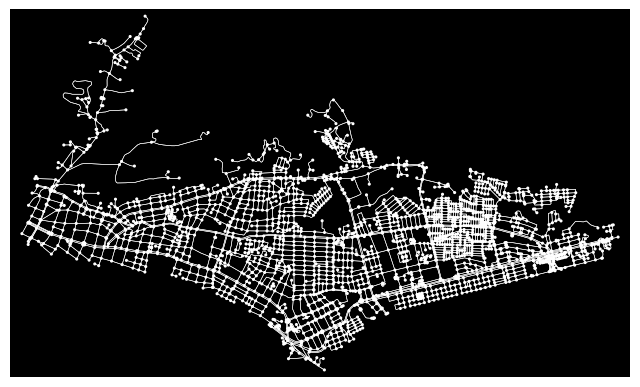

In [3]:
import osmnx as ox
import geopandas as gpd
from shapely.ops import unary_union

place_polygons = ox.geocode_to_gdf(PLACE_NAMES)

aoi_union = unary_union(place_polygons.geometry)
place_polygon = gpd.GeoDataFrame(geometry=[aoi_union], crs=place_polygons.crs)

# (EPSG:9377 is for Ibagué)
place_polygon = place_polygon.to_crs("EPSG:9377")

# Buffer by 200 m
place_polygon["geometry"] = place_polygon.buffer(200)

# Back to WGS84 (EPSG:4326) for OSMnx
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the walkable network inside the buffered polygon
graph = ox.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="walk",
    simplify=True
)

# Quick visual check
fig, ax = ox.plot_graph(
    graph,
    node_size=5,
    edge_color="white",
    bgcolor="black",
    edge_linewidth=0.4
)

In [4]:
stats = ox.basic_stats(graph); stats["n"], stats["m"]

(2786, 8146)

**Summary of the buffered AOI download**

- Network type: *walk*
- Communes included: 4 and 5 of Ibagué (Tolima, Colombia)
- Buffer applied: 200 m
- Nodes: 2786
- Edges: 8146

## 1.1. Data overview

Now that we obtained a complete network graph for the travel mode we specified
(walking), we can take a closer look at which attributes are assigned to the
nodes and edges of the network.

In [5]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid    highway lanes         name  oneway  \
u         v          key                                                     
270728747 287886868  0    1068485709    primary     2     Calle 19   False   
          287125280  0    1068485711    primary     2     Calle 19   False   
          9695484678 0    1068485712    primary     2    Carrera 8   False   
          5774288887 0     534914331  secondary     2    Carrera 8   False   
          5640970668 0     628155409   tertiary     2  Diagonal 19   False   

                         reversed      length  \
u         v          key                        
270728747 287886868  0       True   16.865184   
          287125280  0      False   11.129592   
          9695484678 0       True   18.605544   
          5774288887 0      False  145.370531   
          5640970668 0      False   22.427993   

                                                                   geometry  \
u         v          key                                                      
270728747 287886868  0    LINESTRING (-75.23225 4.44556, -75.23224 4.44541)   
          287125280  0    LINESTRING (-75.23225 4.44556, -75.23232 4.44548)   
          9695484678 0    LINESTRING (-75.23225 4.44556, -75.23212 4.44546)   
          5774288887 0    LINESTRING (-75.23225 4.44556, -75.23245 4.445...   
          5640970668 0    LINESTRING (-75.23225 4.44556, -75.2322 4.4456...   

                         service bridge maxspeed junction access width  
u         v          key                                                
270728747 287886868  0       NaN    NaN      NaN      NaN    NaN   NaN  
          287125280  0       NaN    NaN      NaN      NaN    NaN   NaN  
          9695484678 0       NaN    NaN      NaN      NaN    NaN   NaN  
          5774288887 0       NaN    NaN      NaN      NaN    NaN   NaN  
          5640970668 0       NaN    NaN      NaN      NaN    NaN   NaN

In [6]:
edges["highway"].value_counts()

highway
residential                      4438
footway                          1004
secondary                         634
primary                           558
service                           546
tertiary                          536
path                              236
primary_link                       48
unclassified                       22
[footway, residential]             17
[residential, footway]             17
pedestrian                         16
[footway, steps]                   16
steps                              16
[residential, steps]               12
track                               6
[steps, path]                       4
[residential, steps, footway]       3
[residential, path]                 2
[footway, service]                  2
services                            2
[residential, tertiary]             2
secondary_link                      2
[track, residential]                2
[residential, track]                2
[footway, residential, steps]       1
[pat

## 1.2. Transform to projected reference system

The network data’s cartographic reference system (CRS) is WGS84 (EPSG:4326), a
geographic reference system. That means, distances are recorded and expressed
in degrees, areas in square-degrees. This is not convenient for network
analyses, such as finding a shortest path.

In [7]:
graph = ox.project_graph(graph, to_crs="EPSG:9377")

# Extract nodes and edges in the projected CRS
nodes, edges = ox.graph_to_gdfs(graph)

# Confirm CRS
nodes.crs

<Projected CRS: EPSG:9377>
Name: MAGNA-SIRGAS 2018 / Origen-Nacional
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Coordinate Operation:
- name: Colombia Transverse Mercator
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia 2018
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## 2. Analysing network properties

Now that we have prepared a routable network graph, we can turn to the more
analytical features of OSMnx, and extract information about the network.

In [8]:
# Calculate network statistics
ox.basic_stats(graph)

{'n': 2786,
 'm': 8146,
 'k_avg': 5.84781048097631,
 'edge_length_total': 437099.9344834631,
 'edge_length_avg': 53.658229128831714,
 'streets_per_node_avg': 2.979181622397703,
 'streets_per_node_counts': {0: 0,
  1: 339,
  2: 0,
  3: 1841,
  4: 596,
  5: 8,
  6: 1,
  7: 0,
  8: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12167982770997847,
  2: 0.0,
  3: 0.6608040201005025,
  4: 0.2139267767408471,
  5: 0.002871500358937545,
  6: 0.0003589375448671931,
  7: 0.0,
  8: 0.0003589375448671931},
 'intersection_count': 2447,
 'street_length_total': 218549.9672417296,
 'street_segment_count': 4073,
 'street_length_avg': 53.65822912883123,
 'circuity_avg': 1.041801623514623,
 'self_loop_proportion': 0.0004910385465259023}

This does not yet yield all interesting characteristics of our network, as
OSMnx does not automatically take the area covered by the network into
consideration. We can do that manually, by, first, delineating the [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) of the network (of an ’unary’
union of all its features), and then, second, computing the area of this hull.

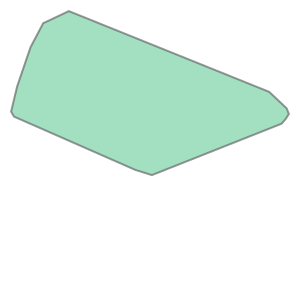

In [9]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [10]:
stats = ox.basic_stats(graph, area=convex_hull.area)
stats

{'n': 2786,
 'm': 8146,
 'k_avg': 5.84781048097631,
 'edge_length_total': 437099.9344834631,
 'edge_length_avg': 53.658229128831714,
 'streets_per_node_avg': 2.979181622397703,
 'streets_per_node_counts': {0: 0,
  1: 339,
  2: 0,
  3: 1841,
  4: 596,
  5: 8,
  6: 1,
  7: 0,
  8: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12167982770997847,
  2: 0.0,
  3: 0.6608040201005025,
  4: 0.2139267767408471,
  5: 0.002871500358937545,
  6: 0.0003589375448671931,
  7: 0.0,
  8: 0.0003589375448671931},
 'intersection_count': 2447,
 'street_length_total': 218549.9672417296,
 'street_segment_count': 4073,
 'street_length_avg': 53.65822912883123,
 'circuity_avg': 1.041801623514623,
 'self_loop_proportion': 0.0004910385465259023,
 'node_density_km': 227.15080683832971,
 'intersection_density_km': 199.51113579805917,
 'edge_density_km': 35638.048380078864,
 'street_density_km': 17819.024190039272}

## 2.1 Street-class overview
Some segments carry multiple `highway` tags (stored as Python lists).  
We explode those lists so each tag is counted separately, then compute totals
and draw the bar chart.

In [11]:
# Create a clean copy of edges and explode list-type highway tags
edges_fix = edges.copy()

# Ensure every entry is a list, then explode into one row per tag
edges_fix["highway"] = edges_fix["highway"].apply(
    lambda x: x if isinstance(x, list) else [x]
)
edges_fix = edges_fix.explode("highway")

In [12]:
# Total and mean lengths for residential / primary / secondary
target = ["residential", "primary", "secondary"]

length_tbl = (
    edges_fix[edges_fix["highway"].isin(target)]
    .groupby("highway")["length"]
    .agg(total_km=lambda x: x.sum() / 1000,
         mean_m=lambda x: x.mean())
    .round({"total_km": 1, "mean_m": 1})
    .rename_axis(None)
)

# Save numbers for the markdown template
tot_res, mean_res = length_tbl.loc["residential"]
tot_prim, mean_prim = length_tbl.loc["primary"]
tot_sec,  mean_sec  = length_tbl.loc["secondary"]

length_tbl  # display tidy table

,total_km,mean_m
primary,39.2,70.2
residential,243.1,54.1
secondary,45.1,71.2


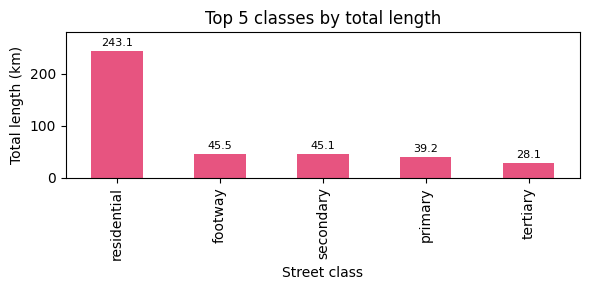

In [13]:
# 🚀 Street-class stats with list handling
import matplotlib.pyplot as plt

edges_fix = edges.copy()

# Ensure every value is a list, then explode
edges_fix["highway"] = edges_fix["highway"].apply(
    lambda x: x if isinstance(x, list) else [x]
)
edges_fix = edges_fix.explode("highway")

# Totals and means
stats_df = (
    edges_fix.groupby("highway")["length"]
    .agg(total_km=lambda x: x.sum() / 1000,
         mean_m=lambda x: x.mean())
    .sort_values("total_km", ascending=False)
)

# Bar chart – five longest classes (fuchsia + tidy labels)
top5 = stats_df.head(5)

fig, ax = plt.subplots(figsize=(6, 3))
bars = top5["total_km"].plot.bar(ax=ax, color="#e75480")

ax.set_ylabel("Total length (km)")
ax.set_xlabel("Street class")
ax.set_title("Top 5 classes by total length")

# Extra head-room
upper = top5["total_km"].max() * 1.15   # 15 % above the highest bar
ax.set_ylim(0, upper)

# Value labels
for bar in bars.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + upper * 0.02,           # 2% of the total range as offset
        f"{height:.1f}",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()

## 3. Shortest path analysis

Let’s calculate the shortest path between two points using
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

## 3.1 Origin & destination points  
We pick two landmarks inside our study area and geocode them, then re-project
the points to the same CRS as the network (EPSG 9377).

**Origin Point**: EUROVET SPORT, Ibagué
**Destination Pint**: Presto centro médico javeriano, Ibagué

In [14]:
from shapely.geometry import Point
import geopandas as gpd

# Points coordinates
origin_pt      = Point(-75.2192341, 4.4425374)
destination_pt = Point(-75.2104214, 4.4335753)

# Proyecta al CRS de la red
origin_pt      = gpd.GeoSeries([origin_pt], crs="EPSG:4326").to_crs(edges.crs)[0]
destination_pt = gpd.GeoSeries([destination_pt], crs="EPSG:4326").to_crs(edges.crs)[0]

In [15]:
orig_node = ox.distance.nearest_nodes(graph, origin_pt.x, origin_pt.y)
dest_node = ox.distance.nearest_nodes(graph, destination_pt.x, destination_pt.y)

print(orig_node)
print(dest_node)

365381228
542475936


## 3.2 Nearest network nodes & shortest path (Dijkstra by 'length')
We snap each landmark to the closest node in the walk network and compute the
shortest path by edge length (metres).

In [16]:
# 🔍 Snap to nearest nodes
orig_node = ox.distance.nearest_nodes(graph, origin_pt.x, origin_pt.y)
dest_node = ox.distance.nearest_nodes(graph, destination_pt.x, destination_pt.y)
orig_node, dest_node

(365381228, 542475936)

## 3.3. Routing

Now we are ready for routing and to find the shortest path between the
origin and target location. We will use
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

The function accepts three mandatory parameters: a graph, an origin node id, and
a destination node id, and two optional parameters: `weight` can be set to
consider a different *cost impedance* than the length of the route, and `cpus`
controls parallel computation of many routes.

In [17]:
# 🛣️  Shortest path (Dijkstra by 'length')
route = ox.shortest_path(graph, orig_node, dest_node, weight="length")
route

[365381228,
 338493790,
 290555704,
 368379977,
 368296120,
 290555394,
 338493435,
 290556070,
 338161336,
 290555252,
 9339461383,
 9340002507,
 361240898,
 4978538009,
 361240996,
 361241005,
 7328115110,
 5932558963,
 361241196,
 9337253647,
 9339772886,
 542475953,
 8815741369,
 287756991,
 542475936]

As a result we get a list of all the nodes that are along the shortest path. 

We could extract the locations of those nodes from the `nodes`
GeoDataFrame and create a LineString presentation of the points, but luckily,
OSMnx can do that for us and we can plot shortest path by using
`plot_graph_route()` function:

Shortest walk path: 1.69 km


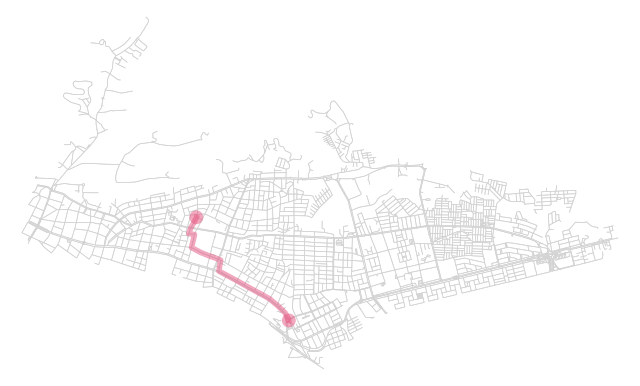

In [18]:
# 📏 Path length in km
length_m = 0
for u, v in zip(route[:-1], route[1:]):
    # each edge can have multiple keys; take the first (0)
    length_m += graph[u][v][0]["length"]
print(f"Shortest walk path: {length_m/1000:.2f} km")

# 🖼️  Plot route
fig, ax = ox.plot_graph_route(
    graph,
    route,
    route_color="#e75480",
    node_size=0,
    bgcolor="white",
    edge_color="lightgray",
    edge_linewidth=0.5
)

## 3.4 🚀 Alternative route (tertiary excluded)

We build a sub-graph that excludes edges tagged as **tertiary**,  
compute the shortest path again, and compare its length with the original route.

In [19]:
# Re-build alternative graph without "residential" segments
banned = {"tertiary"}

edges_drop = []
for u, v, k, data in graph.edges(keys=True, data=True):
    tags = data.get("highway")
    tags = tags if isinstance(tags, list) else [tags]
    if any(tag in banned for tag in tags):
        edges_drop.append((u, v, k))

G_alt = graph.copy()
G_alt.remove_edges_from(edges_drop)
print(f"Dropped {len(edges_drop):,} edges (tertiary)")

Dropped 538 edges (tertiary)


In [20]:
# Existing route verification

import networkx as nx

try:
    alt_route = ox.shortest_path(G_alt, orig_node, dest_node, weight="length")
except nx.NetworkXNoPath:
    alt_route = None

if alt_route is None:
    print("⚠️  No path found under current filter. Try relaxing the banned set or choosing other points.")
else:
    alt_len_m = sum(
        G_alt[u][v][0]["length"] for u, v in zip(alt_route[:-1], alt_route[1:])
    )
    print(f"Alternative path length : {alt_len_m/1000:.2f} km")
    print(f"Original path length    : {length_m/1000:.2f} km")
    print(f"Extra distance          : {(alt_len_m-length_m)/1000:.2f} km")

Alternative path length : 1.74 km
Original path length    : 1.69 km
Extra distance          : 0.04 km


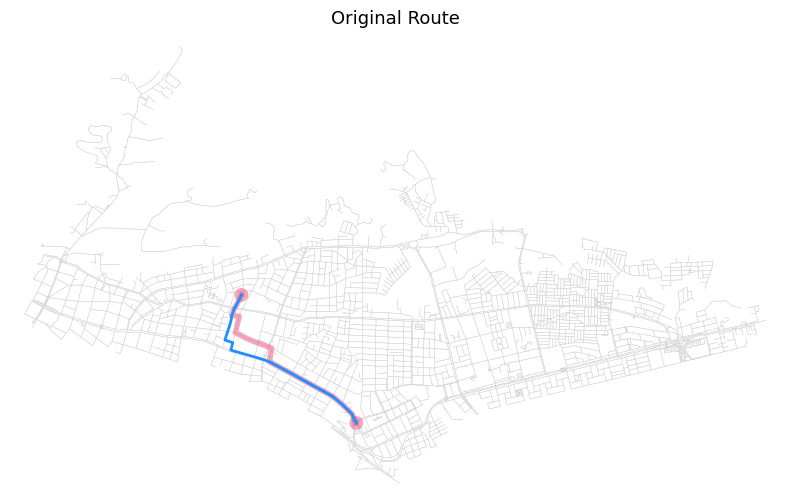

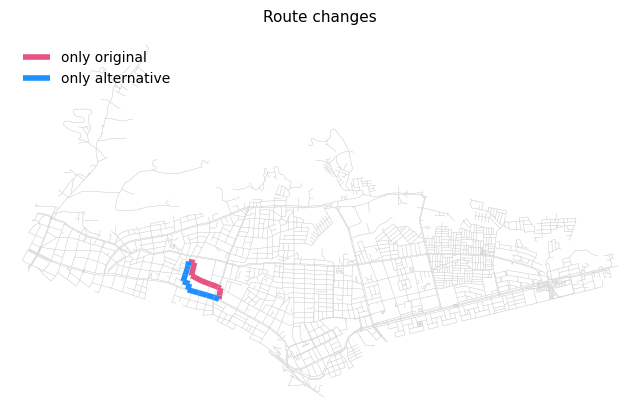

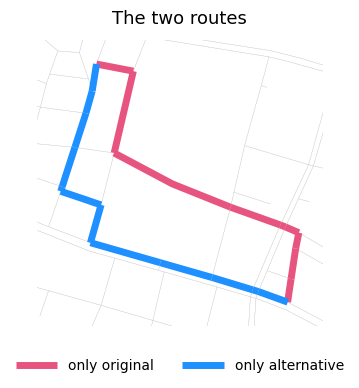

In [21]:
# Visualization

import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from shapely.ops import unary_union

# --------------------------------------------------
# 1) Original and alternative routes over full network
# --------------------------------------------------
fig, ax = ox.plot_graph_route(
    graph, route,
    route_color="#e75480",        # rosa
    route_linewidth=4,
    edge_color="lightgray", edge_linewidth=0.3,
    node_size=0, bgcolor="white",
    show=False, close=False       # ← ¡IMPORTANTE!
)

ox.plot_graph_route(
    graph, alt_route,
    ax=ax,
    route_color="dodgerblue",     # azul
    route_linewidth=2,
    route_alpha=1,
    orig_dest_size=0,
    show=False, close=False       # ← mantiene la misma figura abierta
)

ax.set_title("Original Route", fontsize=13, pad=10)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2) Highlight only-different segments (zoomed to whole city)
# --------------------------------------------------

# Build (u, v, k) sets for each route
pairs_orig = list(zip(route[:-1], route[1:]))
pairs_alt  = list(zip(alt_route[:-1], alt_route[1:]))
triples_orig = {(u, v, 0) for u, v in pairs_orig}
triples_alt  = {(u, v, 0) for u, v in pairs_alt}

only_orig = triples_orig - triples_alt
only_alt  = triples_alt  - triples_orig

def edges_to_gdf(G, triples):
    """Return edge GeoDataFrame for (u,v,k) triples."""
    sub = G.edge_subgraph(triples).copy()
    return ox.graph_to_gdfs(sub, nodes=False, edges=True)

gdf_orig = edges_to_gdf(graph, only_orig)
gdf_alt  = edges_to_gdf(graph, only_alt)

fig, ax = ox.plot_graph(
    graph,
    show=False, close=False,
    edge_color="lightgray", edge_linewidth=0.25,
    node_size=0, bgcolor="white"
)
gdf_orig.plot(ax=ax, linewidth=4, color="#e75480", label="only original")
gdf_alt .plot(ax=ax, linewidth=4, color="dodgerblue", label="only alternative")
ax.legend(frameon=False, loc="upper left")
ax.set_title("Route changes", pad=12, fontsize=11)
plt.show()

# --------------------------------------------------
# 3) Tight zoom on the differences (smaller figure)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# fondo muy tenue
ox.plot_graph(
    graph, ax=ax, show=False, close=False,
    edge_color="lightgray", edge_linewidth=0.25,
    node_size=0, bgcolor="white"
)

# segmentos distintos
gdf_orig.plot(ax=ax, linewidth=5, color="#e75480", label="only original")
gdf_alt .plot(ax=ax, linewidth=5, color="dodgerblue", label="only alternative")

# encuadre ajustado (+10 %)
m = 0.10
xmin, ymin, xmax, ymax = unary_union(
    list(gdf_orig.geometry) + list(gdf_alt.geometry)
).bounds
dx, dy = xmax - xmin, ymax - ymin
ax.set_xlim(xmin - dx*m, xmax + dx*m)
ax.set_ylim(ymin - dy*m, ymax + dy*m)

# título
ax.set_title("The two routes", fontsize=13, pad=12)

# leyenda *fuera* del eje, centrada abajo
ax.legend(
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.07),   # 7 % debajo del eje
    ncol=2, handlelength=3
)

plt.tight_layout()
plt.show()

**Alternative route — tertiary streets excluded**

The filtered sub-graph removes all segments tagged *tertiary*.  
A valid path still exists, but it detours around those collector roads:

| metric | original | alternative |
|--------|----------|-------------|
| length | **1.69 km** | **1.74 km** |
| extra  | — | **+ 0.04 km** |

Excluding tertiary streets forces onto quieter residential links while adding only 40 m to the trip — a trade-off that may improve comfort without significantly increasing distance.

## 3.5 Shortest path (A* heuristic = euclidean)

A* shortest walk path: 1.69 km


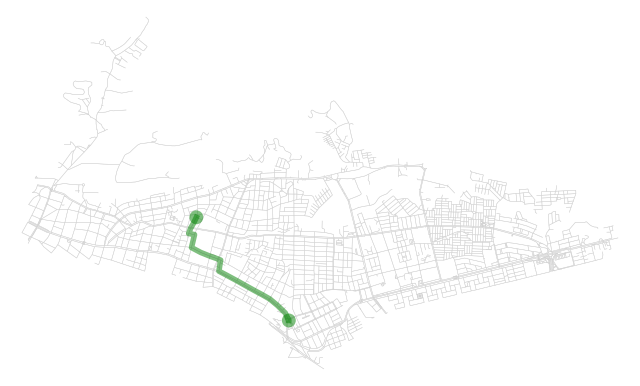

In [22]:
# -------------------------------------------
# Shortest-path with A* (heuristic = euclidean)
# -------------------------------------------
import networkx as nx
import osmnx as ox
import numpy as np

G = graph          # <= añade esta línea

# 1) heuristic: straight-line distance -----------------------
def euclidean_heuristic(u, v):
    xu, yu = G.nodes[u]["x"], G.nodes[u]["y"]
    xv, yv = G.nodes[v]["x"], G.nodes[v]["y"]
    return np.hypot(xu - xv, yu - yv)        # metres

# 2) run A* -----------------------------------------------
astar_route = nx.astar_path(
    G, orig_node, dest_node,
    heuristic=euclidean_heuristic,
    weight="length"
)
astar_len_m = nx.astar_path_length(
    G, orig_node, dest_node,
    heuristic=euclidean_heuristic,
    weight="length"
)
print(f"A* shortest walk path: {astar_len_m/1000:.2f} km")

# 3) quick plot -------------------------------------------
fig, ax = ox.plot_graph_route(
    G, astar_route,
    route_color="green", route_linewidth=4,
    edge_color="lightgray", edge_linewidth=0.3,
    node_size=0, bgcolor="white"
)

### Distance-based shortest paths

| metric | Dijkstra&nbsp;(OSMnx) | A* |
|:------ | --------------------: | --:|
| length | **1.69 km** | **1.69 km** |
| extra  | — | ± 0.00 km |

Both algorithms minimise edge length, so—given the same network and origin/destination—they yield an identical route.  
A* reaches the solution faster on large graphs (it uses the straight-line heuristic) but, for this small study area, the performance difference is negligible.

## 4. Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path, then we create a LineString out of the Point geometries of the nodes, finally we make a GeoDataFrame having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.:

In [23]:
# Build GeoDataFrames for both routes

import osmnx as ox
from shapely.geometry import LineString
import geopandas as gpd

# ---------- helper ----------
def edges_to_gdf(G, route_nodes):
    """Return GeoDataFrame of edges traversed by a route."""
    pairs   = list(zip(route_nodes[:-1], route_nodes[1:]))
    triples = {(u, v, 0) for u, v in pairs}          # assume key = 0
    sub     = G.edge_subgraph(triples).copy()
    return ox.graph_to_gdfs(sub, nodes=False, edges=True)

# ---------- ORIGINAL (Dijkstra) ----------
route_geom_dij  = gpd.GeoSeries(
    [LineString(nodes.loc[route].geometry.values)],
    crs=nodes.crs, name="geometry"
)
route_edges_dij = edges_to_gdf(graph, route)
route_nodes_dij = nodes.loc[route]

# ---------- ALTERNATIVE (A*) ----------
route_geom_ast  = gpd.GeoSeries(
    [LineString(nodes.loc[alt_route].geometry.values)],
    crs=nodes.crs, name="geometry"
)
route_edges_ast = edges_to_gdf(graph, alt_route)
route_nodes_ast = nodes.loc[alt_route]

# add simple attributes ----------------------------------------
route_geom_dij = gpd.GeoDataFrame(
    {"method": ["dijkstra"], "length_m": [route_edges_dij.length.sum()]},
    geometry=route_geom_dij
)
route_geom_ast = gpd.GeoDataFrame(
    {"method": ["astar"], "length_m": [route_edges_ast.length.sum()]},
    geometry=route_geom_ast
)

In [24]:
# Define output path

from pathlib import Path

BASE_DIR    = Path(".").resolve() / "data"      # adjust as you like
BASE_DIR.mkdir(exist_ok=True, parents=True)

FULL_GPKG   = BASE_DIR / "route_full.gpkg"
print(FULL_GPKG)

/notebooks/workshop4-network-analysis/data/route_full.gpkg


In [25]:
# Write every layer to the same Geopackage (for both short routes)
DRIVER = "GPKG"

# overwrite if layers already exist
FULL_GPKG.unlink(missing_ok=True)

# ----- lines -----
route_geom_dij.to_file(FULL_GPKG, layer="dijkstra_line", driver=DRIVER)
route_geom_ast.to_file(FULL_GPKG, layer="astar_line",    driver=DRIVER)

# ----- edges -----
route_edges_dij.to_file(FULL_GPKG, layer="dijkstra_edges", driver=DRIVER)
route_edges_ast.to_file(FULL_GPKG, layer="astar_edges",    driver=DRIVER)

# ----- nodes -----
route_nodes_dij.to_file(FULL_GPKG, layer="dijkstra_nodes", driver=DRIVER)
route_nodes_ast.to_file(FULL_GPKG, layer="astar_nodes",    driver=DRIVER)

In [40]:
pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Inspect layers to confrim
import fiona
print("Layers inside", FULL_GPKG.name, "→")
for layer in fiona.listlayers(FULL_GPKG):
    print(" •", layer)

Layers inside route_full.gpkg →
 • dijkstra_line
 • astar_line
 • dijkstra_edges
 • astar_edges
 • dijkstra_nodes
 • astar_nodes


In [28]:
edges.head()

osmid    highway lanes         name  oneway  \
u         v          key                                                     
270728747 287886868  0    1068485709    primary     2     Calle 19   False   
          287125280  0    1068485711    primary     2     Calle 19   False   
          9695484678 0    1068485712    primary     2    Carrera 8   False   
          5774288887 0     534914331  secondary     2    Carrera 8   False   
          5640970668 0     628155409   tertiary     2  Diagonal 19   False   

                         reversed      length  \
u         v          key                        
270728747 287886868  0       True   16.865184   
          287125280  0      False   11.129592   
          9695484678 0       True   18.605544   
          5774288887 0      False  145.370531   
          5640970668 0      False   22.427993   

                                                                   geometry  \
u         v          key                                                      
270728747 287886868  0    LINESTRING (4752385.423 2049604.891, 4752386.8...   
          287125280  0    LINESTRING (4752385.423 2049604.891, 4752378.2...   
          9695484678 0    LINESTRING (4752385.423 2049604.891, 4752400.2...   
          5774288887 0    LINESTRING (4752385.423 2049604.891, 4752363.8...   
          5640970668 0    LINESTRING (4752385.423 2049604.891, 4752390.7...   

                         maxspeed service bridge junction access width  
u         v          key                                                
270728747 287886868  0        NaN     NaN    NaN      NaN    NaN   NaN  
          287125280  0        NaN     NaN    NaN      NaN    NaN   NaN  
          9695484678 0        NaN     NaN    NaN      NaN    NaN   NaN  
          5774288887 0        NaN     NaN    NaN      NaN    NaN   NaN  
          5640970668 0        NaN     NaN    NaN      NaN    NaN   NaN

### 🚀 **Now it’s your turn! — Extending your analysis**

1. **Create** a 50 m buffer around the route and select buildings intersecting it.  
2. **Count** buildings both in total and by `building` tag within this corridor.  
3. **Export** the result to `buildings_along_route.geojson`.  

> 💡 Try `buildings[buildings.intersects(buffer)]` or a spatial overlay with GeoPandas.



## 5. Building counting

### Analyzing Buildings Along the Route

This section creates a **50-meter buffer** around the route, selects **intersecting buildings**, counts them by type using the **`building` tag**, and exports the result to a GeoJSON file.

In [36]:
"route_nodes" in globals(), "nodes" in globals(), "edges" in globals()

(False, True, True)

In [37]:
# recreate route_nodes  -------------------------------------

route_nodes = nodes.loc[route]          # 95 rows, 5 cols  <- quick check
route_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
365381228,2.049318e+06,4.753853e+06,3,NaN,POINT (4753853.09 2049317.693)
338493790,2.049215e+06,4.753801e+06,4,NaN,POINT (4753800.565 2049215.358)
290555704,2.049207e+06,4.753795e+06,4,NaN,POINT (4753795.346 2049206.716)
368379977,2.049154e+06,4.753776e+06,3,NaN,POINT (4753776.077 2049154.195)
368296120,2.049143e+06,4.753835e+06,3,NaN,POINT (4753834.886 2049142.828)


In [38]:
# build LineString & GeoDataFrame  ---------------------------
import shapely.geometry
import geopandas as gpd

# LineString from the points
route_line = shapely.geometry.LineString(list(route_nodes.geometry.values))

# GeoDataFrame with route geometry + list of osmids
route_geom = gpd.GeoDataFrame(
    {"geometry": [route_line],
     "osm_nodes": [route]},          # list of node IDs
    crs=edges.crs                    # EPSG:9377
)

route_geom

,geometry,osm_nodes
0,"LINESTRING (4753853.09 2049317.693, 4753800.56...","[365381228, 338493790, 290555704, 368379977, 3..."


In [40]:
# Download building footprints for the study area ──────────────

PLACE_NAME = "Ibagué, Tolima, Colombia"

buildings = ox.features_from_place(
    PLACE_NAME,
    tags={"building": True}          # any kind of building
).to_crs(edges.crs)                  # reproyectar a EPSG:9377

print(f"Buildings downloaded : {len(buildings):,}")
buildings.head()

Buildings downloaded : 55,988


geometry    building  \
element id                                                        
node    363907721   POINT (4752446.331 2049502.003)      public   
        762932854   POINT (4742512.519 2061857.325)      public   
        1646460474   POINT (4755206.28 2048685.676)  apartments   
        1646465406  POINT (4755758.152 2048880.612)  apartments   
        1756736602    POINT (4744774.53 2046458.49)         yes   

                                            name  source  \
element id                                                 
node    363907721                     Ingeominas     NaN   
        762932854          Inspeccion de policía  survey   
        1646460474          Balcones de Provenza     NaN   
        1646465406  Club Residencial Multicentro     NaN   
        1756736602                      FINCA 21     NaN   

                          addr:housename     addr:housenumber     place shop  \
element id                                                                     
node    363907721                    NaN                  NaN       NaN  NaN   
        762932854                    NaN                  NaN       NaN  NaN   
        1646460474  Balcones de Provenza  Calle 51 Carrera 6a       NaN  NaN   
        1646465406                   NaN                  NaN       NaN  NaN   
        1756736602                   NaN                   21  locality  NaN   

                   leisure sport  ... min_age male community_centre  \
element id                        ...                                 
node    363907721      NaN   NaN  ...     NaN  NaN              NaN   
        762932854      NaN   NaN  ...     NaN  NaN              NaN   
        1646460474     NaN   NaN  ...     NaN  NaN              NaN   
        1646465406     NaN   NaN  ...     NaN  NaN              NaN   
        1756736602     NaN   NaN  ...     NaN  NaN              NaN   

                   industrial diet:vegan fast_food telecom telecom:medium  \
element id                                                                  
node    363907721         NaN        NaN       NaN     NaN            NaN   
        762932854         NaN        NaN       NaN     NaN            NaN   
        1646460474        NaN        NaN       NaN     NaN            NaN   
        1646465406        NaN        NaN       NaN     NaN            NaN   
        1756736602        NaN        NaN       NaN     NaN            NaN   

                   grades type  
element id                      
node    363907721     NaN  NaN  
        762932854     NaN  NaN  
        1646460474    NaN  NaN  
        1646465406    NaN  NaN  
        1756736602    NaN  NaN  

[5 rows x 137 columns]

In [41]:
# 50 m buffer and buildings intersecting it ------------------
# (50 m on each side)         •  metres because CRS is metric
corridor = route_line.buffer(50)

# buildings layer already downloaded (variable “buildings”)
buildings_corridor = buildings[buildings.intersects(corridor)]

# quick stats
print("Total buildings :", len(buildings_corridor))
print(buildings_corridor["building"].value_counts().head())

Total buildings : 228
building
yes              221
apartments         3
office             1
sports_centre      1
terrace            1
Name: count, dtype: int64


In [42]:
# export to GeoJSON -----------------------------------------
buildings_corridor.to_file("buildings_along_route.geojson", driver="GeoJSON")
print("✓ Saved to buildings_along_route.geojson")

✓ Saved to buildings_along_route.geojson


## Summary and Final Remarks

In this notebook we:

1. **Built a multi-commune street network** from OpenStreetMap and projected it to EPSG : 9377.  
2. **Explored the data** – node/edge counts, length by street class, and basic network stats.  
3. **Computed two shortest paths** between selected landmarks  
   * Dijkstra (default in OSMnx)  
   * A* (NetworkX with Euclidean heuristic)  
   and compared distances.  
4. **Generated an alternative route** by excluding *tertiary* streets, visualised differences, and discussed user-focused trade-offs.  
5. **Saved all results** (nodes, edges, lines) to a single GeoPackage *`route_full.gpkg`* for further GIS work.  
6. **Extended the analysis** with a 50 m corridor, counted intersecting buildings, and exported them to *`buildings_along_route.geojson`*.

> This workflow shows how OSMnx + GeoPandas can move seamlessly from network download to advanced spatial analysis and shareable outputs – all inside an open, reproducible Python environment.